# Telecom Customer Churn: Data Ingestion & EDA

This notebook provides an exploratory data analysis (EDA) for the Telco Customer Churn dataset. In the notebook I go you through loading, cleaning, and transforming the data, and analyzing it to find patterns and factors that drive customer churn. The goal is to help understand why customers leave and support better business decisions to reduce attrition.

---

### Telco Customer Churn – Dataset Features:

- customerID – Unique identifier for each customer
- gender – Customer gender (Male / Female)
- SeniorCitizen – Senior citizen status (0 = No, 1 = Yes)
- Partner – Whether the customer has a partner (Yes / No)
- Dependents – Whether the customer has dependents (Yes / No)
- tenure – Number of months the customer has been with the company
- PhoneService – Whether the customer has phone service (Yes / No)
- MultipleLines – Whether the customer has multiple lines (Yes / No / No phone service)
- InternetService – Type of internet service (DSL / Fiber optic / No)
- OnlineSecurity – Whether the customer has online security (Yes / No / No internet service)
- OnlineBackup – Whether the customer has online backup (Yes / No / No internet service)
- DeviceProtection – Whether the customer has device protection (Yes / No / No internet service)
- TechSupport – Whether the customer has tech support (Yes / No / No internet service)
- StreamingTV – Whether the customer streams TV (Yes / No / No internet service)
- StreamingMovies – Whether the customer streams movies (Yes / No / No internet service)
- Contract – Contract type (Month-to-month / One year / Two year)
- PaperlessBilling – Whether the customer has paperless billing (Yes / No)
- PaymentMethod – Payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges – Monthly charges for the customer
- TotalCharges – Total charges accumulated by the customer
- Churn – Target variable; whether the customer churned (Yes / No)

### Imports

In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

from scipy.stats import mannwhitneyu
from sklearn.feature_selection import mutual_info_classif

# Local src
from src.download_data import download_data
from src.clean_column_names import clean_column_names
from src.df_overview import df_overview
from src.schemas import PRE_WRANGLING_SCHEMA

print('Done')

Done


## Data Acquisition

### Data Downloading and Loading

In [28]:
download_path = "blastchar/telco-customer-churn"
download_data(download_path)

Data exists in D:\projects\telecom-customer-churn-prediction\data\01_raw. Skipping.


In [29]:
data_path = os.path.join('..', 'data', '01_raw', 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = pd.read_csv(data_path)

In [30]:
EXPECTED_COLUMNS = PRE_WRANGLING_SCHEMA["expected_columns"]
MIN_ROWS = PRE_WRANGLING_SCHEMA.get("min_rows", 0)

assert set(df.columns) == EXPECTED_COLUMNS, f"Column mismatch: expected {EXPECTED_COLUMNS}, got {set(df.columns)} — check data source."
assert len(df) >= MIN_ROWS, f"Row count {len(df)} is below minimum {MIN_ROWS} — check data source."
print(f"Schema OK: {len(df)} rows, {len(df.columns)} columns.")

Schema OK: 7043 rows, 21 columns.


### Data Wrangling

In [31]:
print("Initial columns:", df.columns.tolist())
df = clean_column_names(df)
print("Cleaned columns:", df.columns.tolist())

Initial columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Cleaned columns: ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents', 'tenure', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'churn']


In [32]:
df_overview(df)
df.head(10)

================================= Shape =================================
(7043, 21)
================================= Info =================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


- the total_charges column is currently stored as an object data type;
- The SeniorCitizen column is encoded as an integer (0/1);
- Conversion steps are necessary for accurate downstream analysis and modeling;

Data types before conversion:
senior_citizen     int64
total_charges     object
dtype: object
Data types after conversion:
senior_citizen     object
total_charges     float64
dtype: object


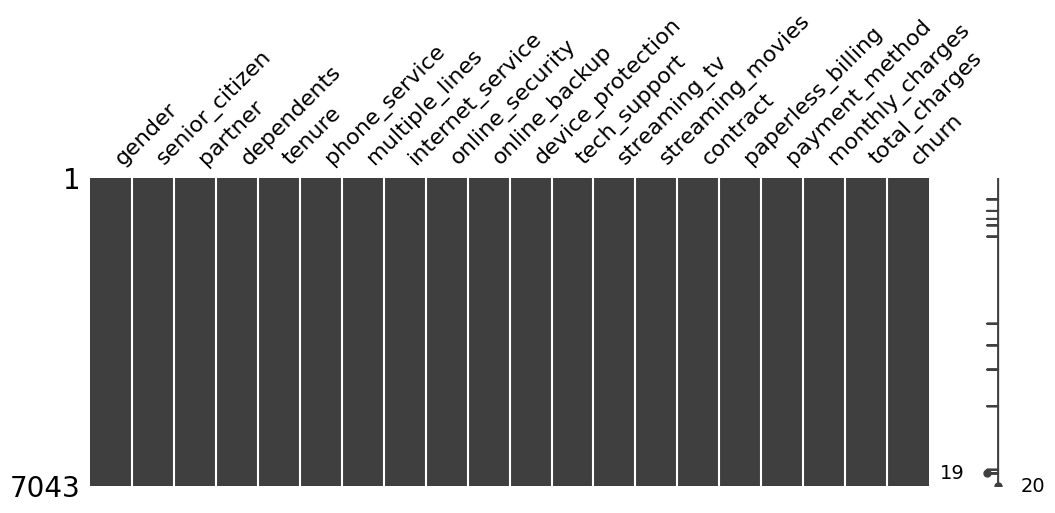

In [33]:
print("Data types before conversion:")
print(df[['senior_citizen', 'total_charges']].dtypes)
df = df.drop(columns='customer_id')
df['senior_citizen'] = df['senior_citizen'].map({0: 'No', 1: 'Yes'})
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
print("Data types after conversion:")
print(df[['senior_citizen', 'total_charges']].dtypes)
msno.matrix(df, figsize=(12, 4))
plt.show()

- dropped customer_id column;
- mapped senior_citizen column with yes and no;
- converted total_charges column to numeric;
- according to df_overview & missingno, NaNs (11) are present after converting;

In [34]:
df[df['total_charges'].isnull()]

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
488,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


- the entries have 0 tenure, which can signal either they are new customers, or (less probable) broken entries;

In [35]:
(df['tenure'] == 0).sum()

np.int64(11)

In [36]:
nan_count = df['total_charges'].isna().sum()
nan_pct = nan_count / len(df) * 100
print(f"Rows with NaN in total_charges: {nan_count} ({nan_pct:.2f}%)")
assert nan_pct < 1.0, f"NaN fraction ({nan_pct:.2f}%) exceeds 1% threshold — investigate before dropping."

df = df.dropna(subset=['total_charges'])
print(f"Dropped {nan_count} rows. Remaining rows: {len(df)}")

Rows with NaN in total_charges: 11 (0.16%)
Dropped 11 rows. Remaining rows: 7032


- dropped rows with NaNs in total_charges since they constitute a very small fraction of the dataset and are unlikely to impact statistical analyses and modeling;
- there are no more customers with 0 tenure in the records;

## Exploratory Data Analysis (EDA)

### Churn Distribution

<Axes: xlabel='churn'>

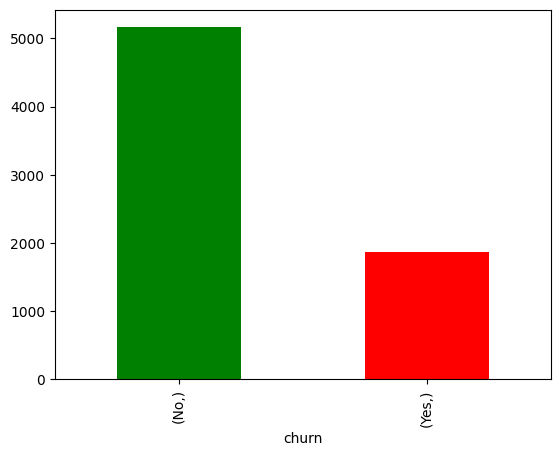

In [37]:
churn = df[['churn']].value_counts()
churn.plot(kind='bar', color=['green', 'red'])

- churn data is strongly imbalanced, approx. 5k/2k (2.5:1);
- use imbalance pipeline later on modeling phase, to ensure correct predicting;

### Categorical Features Distribution with Churn & Weighted Churn

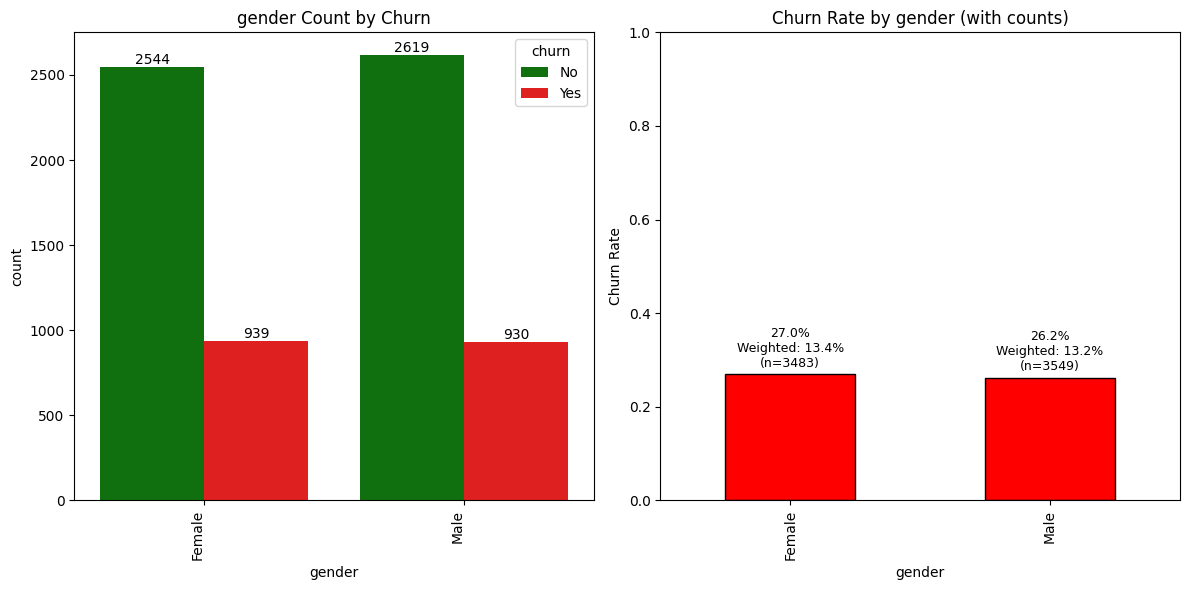

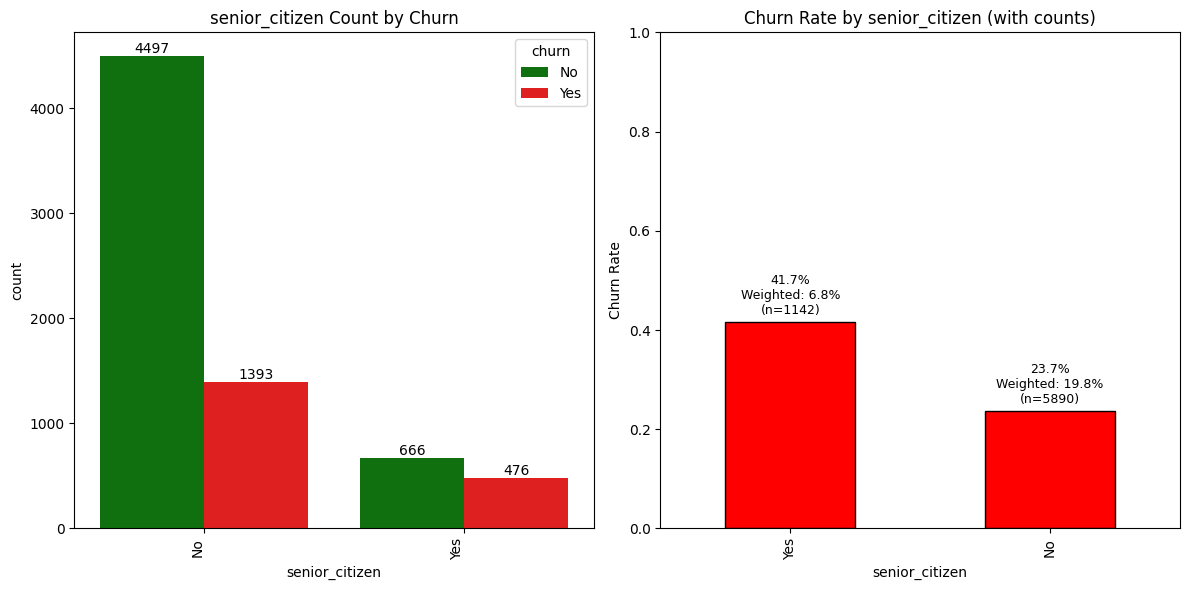

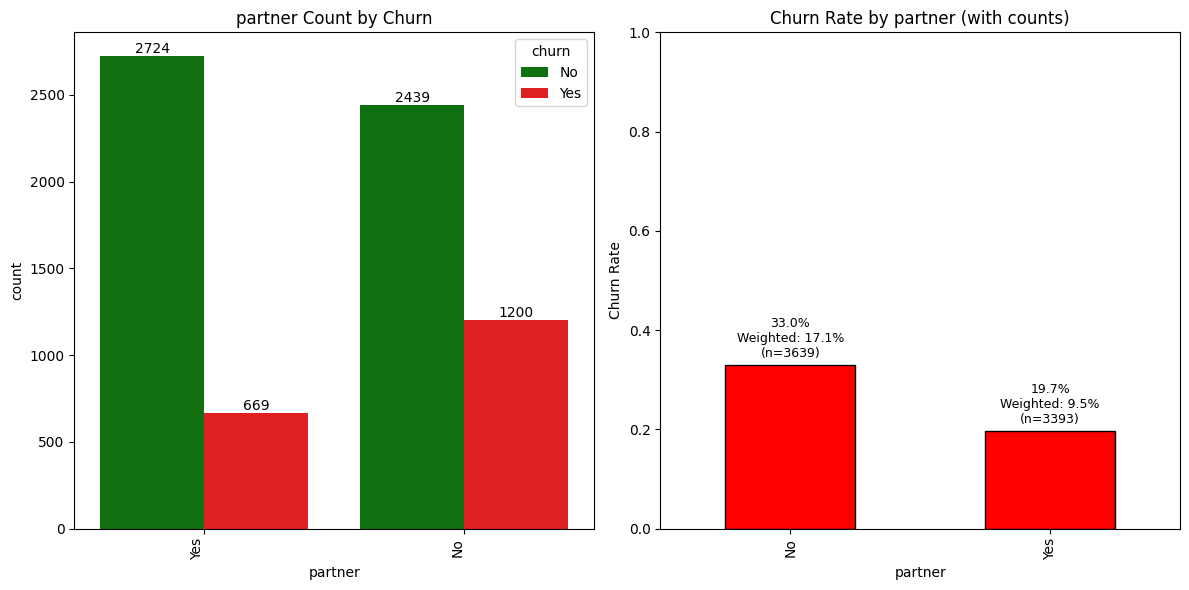

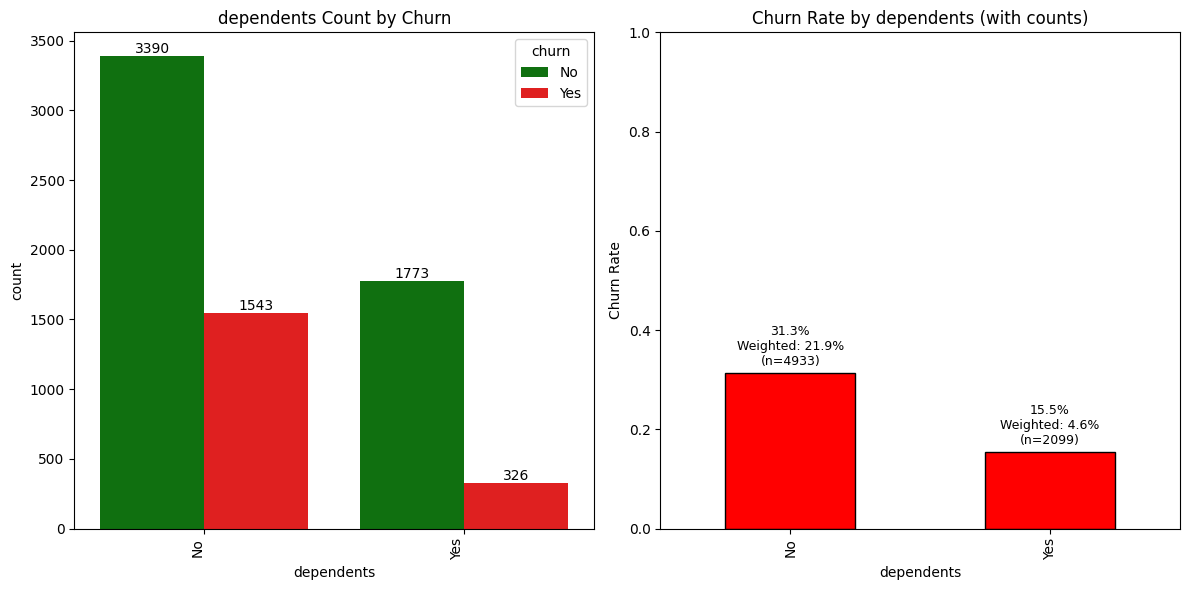

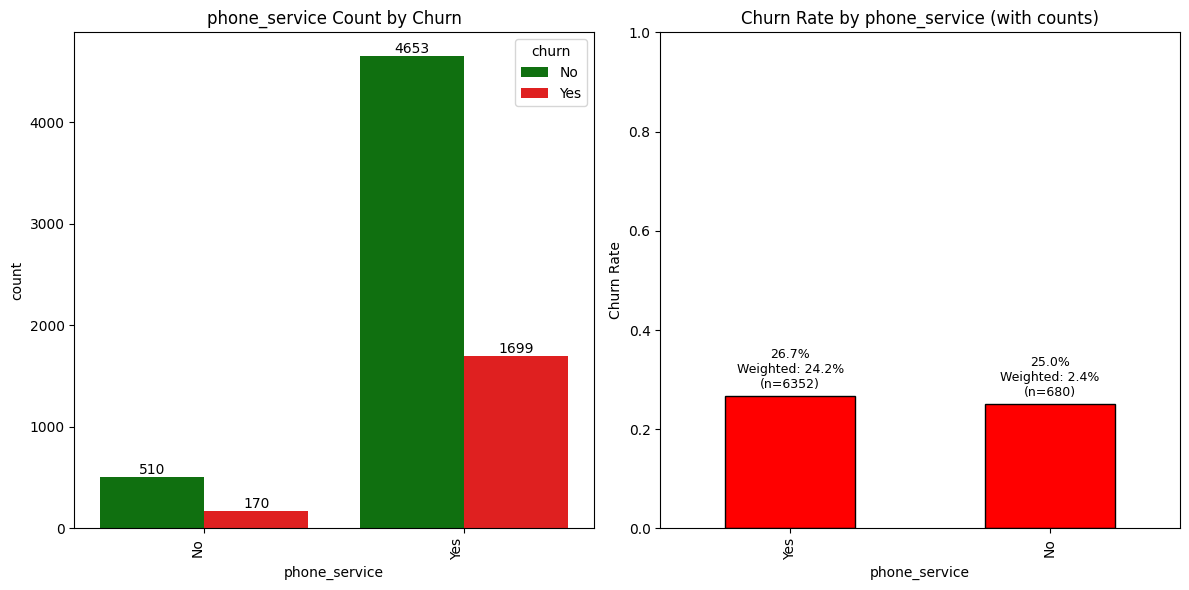

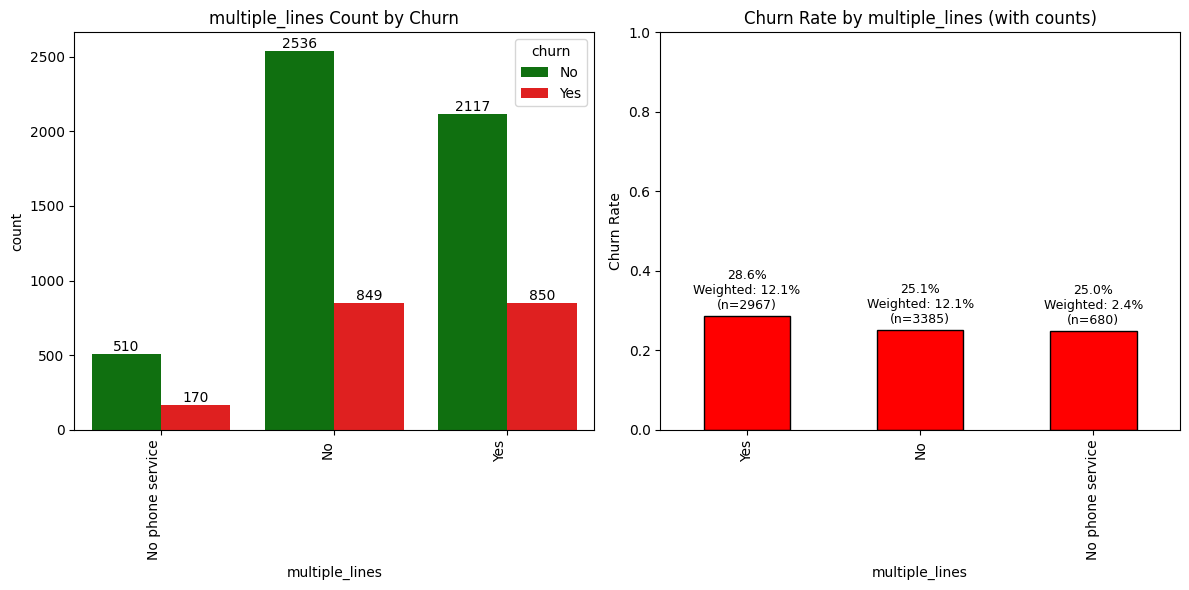

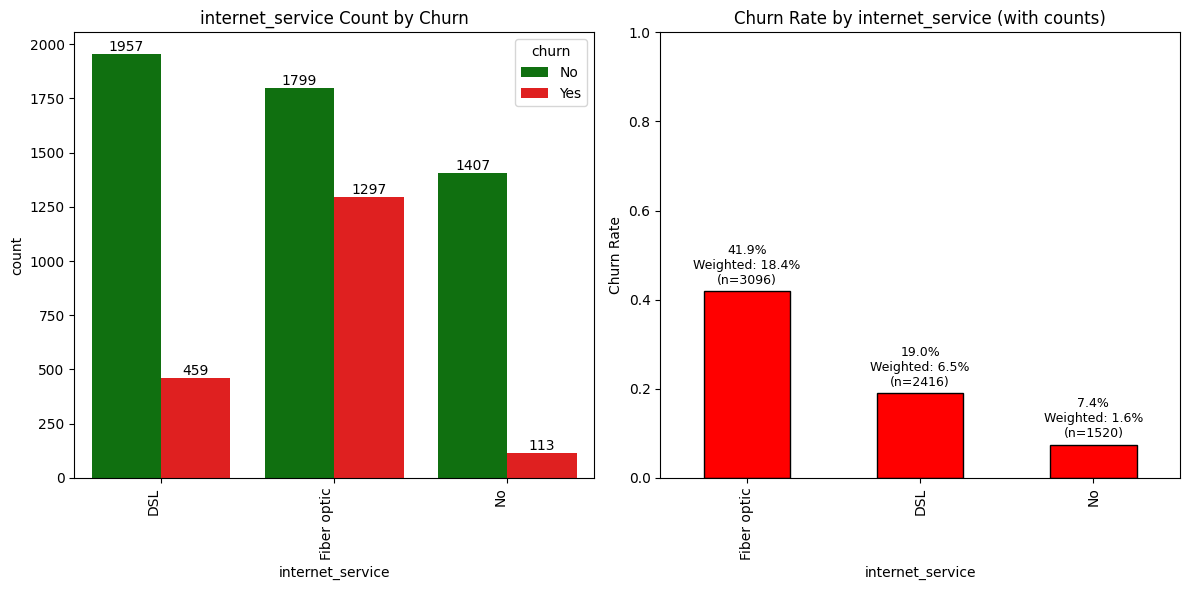

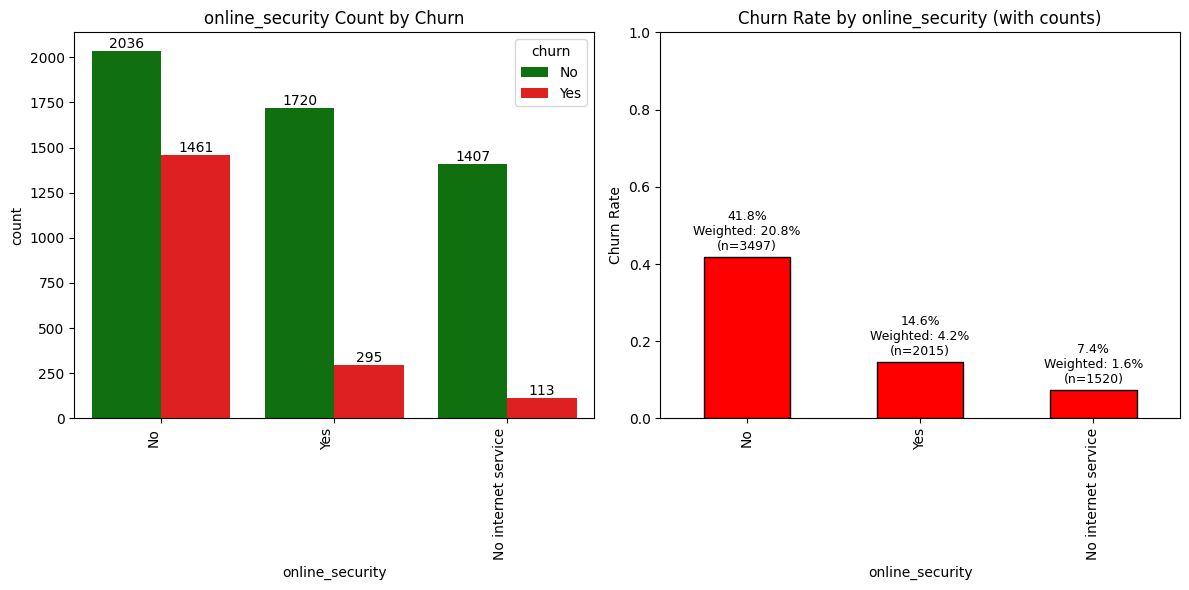

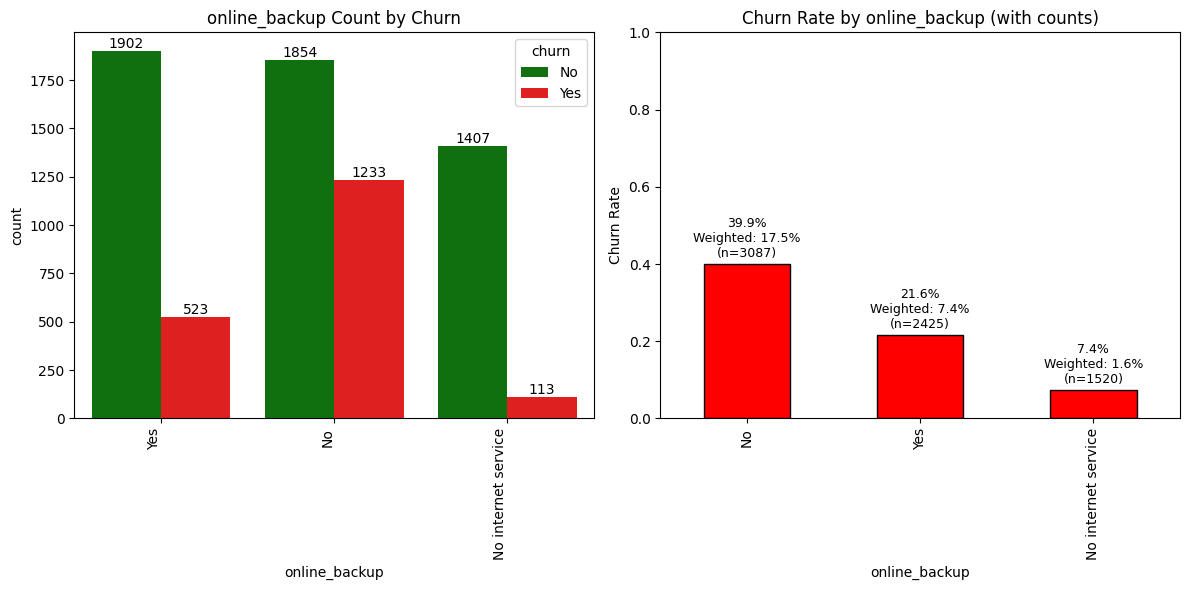

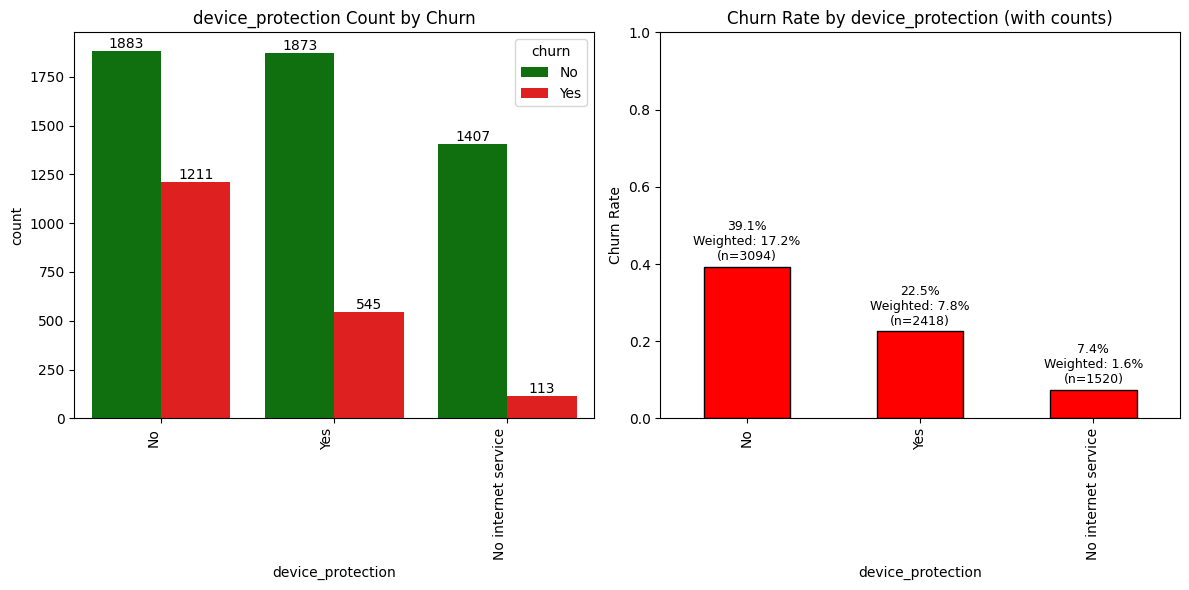

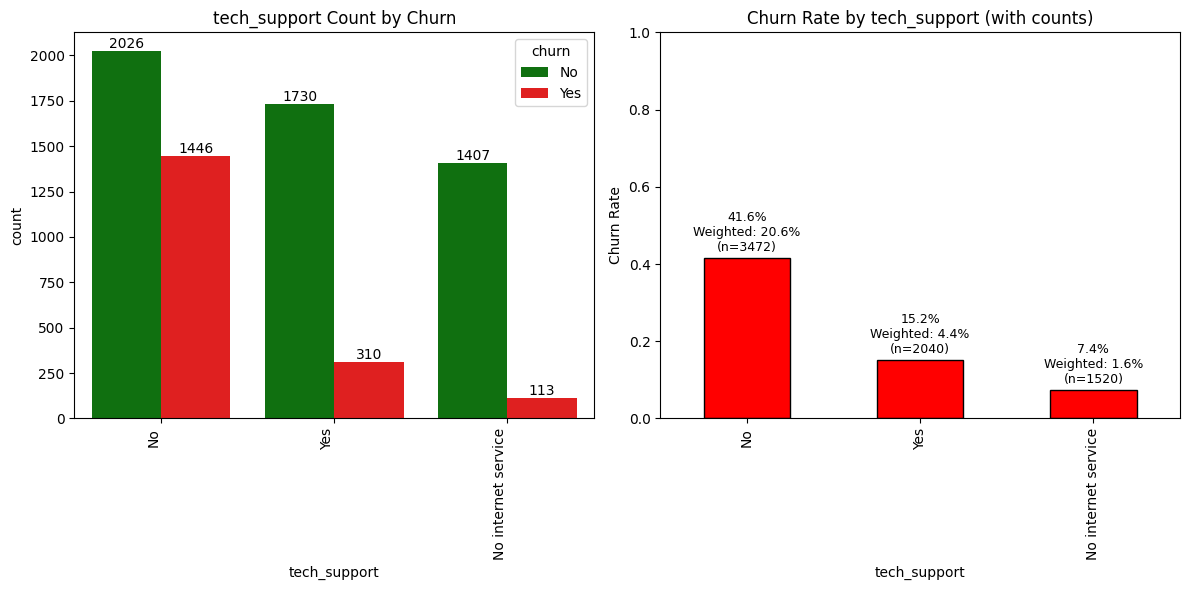

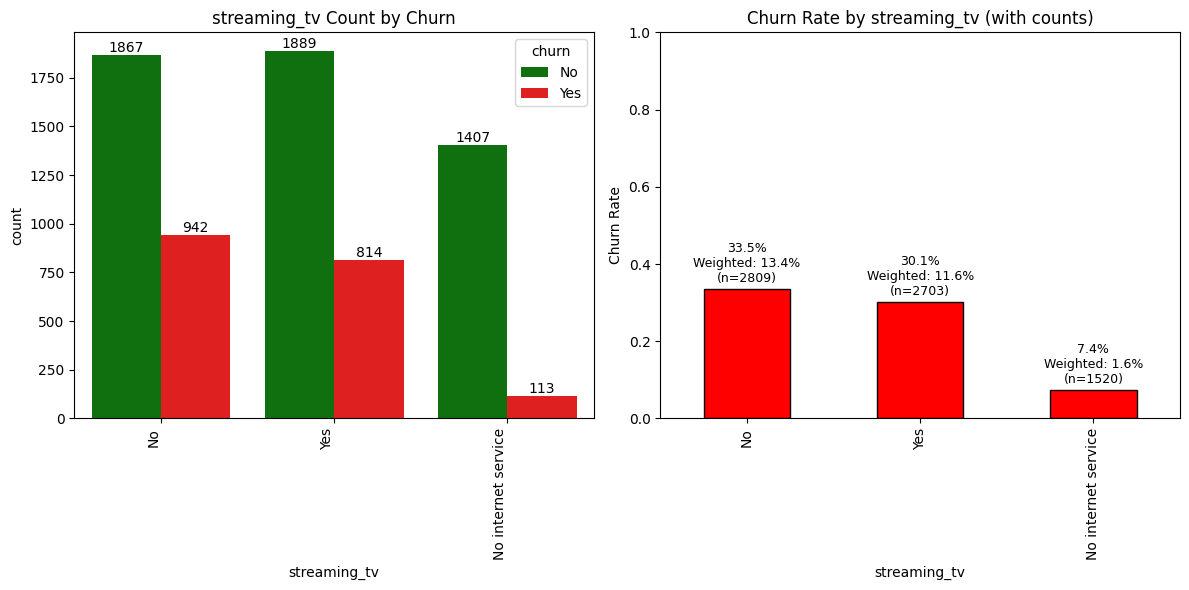

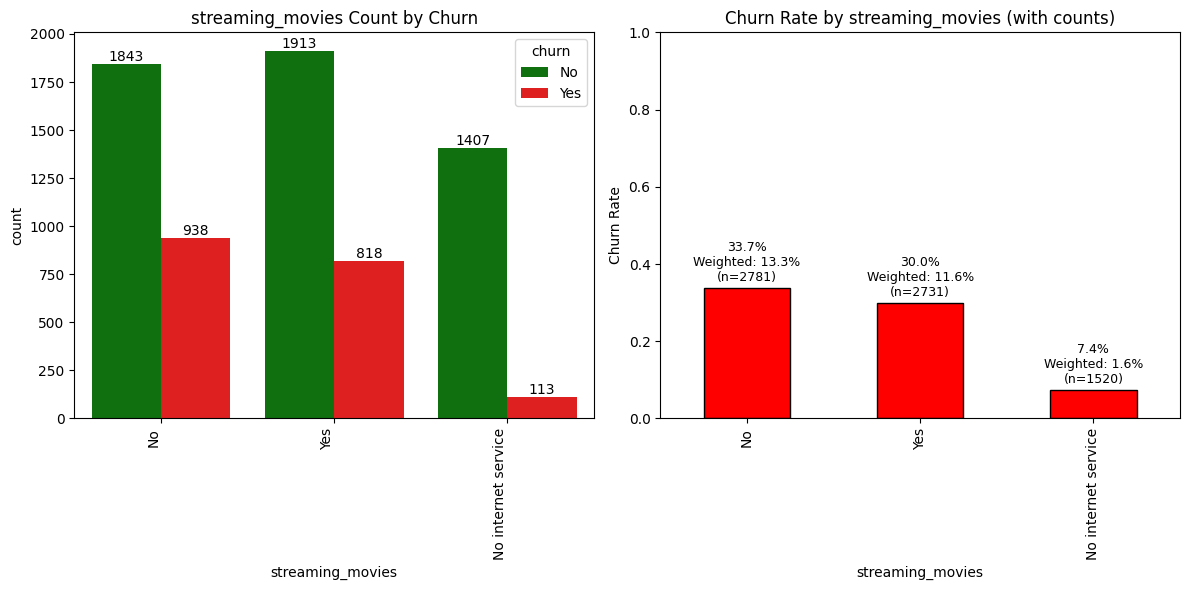

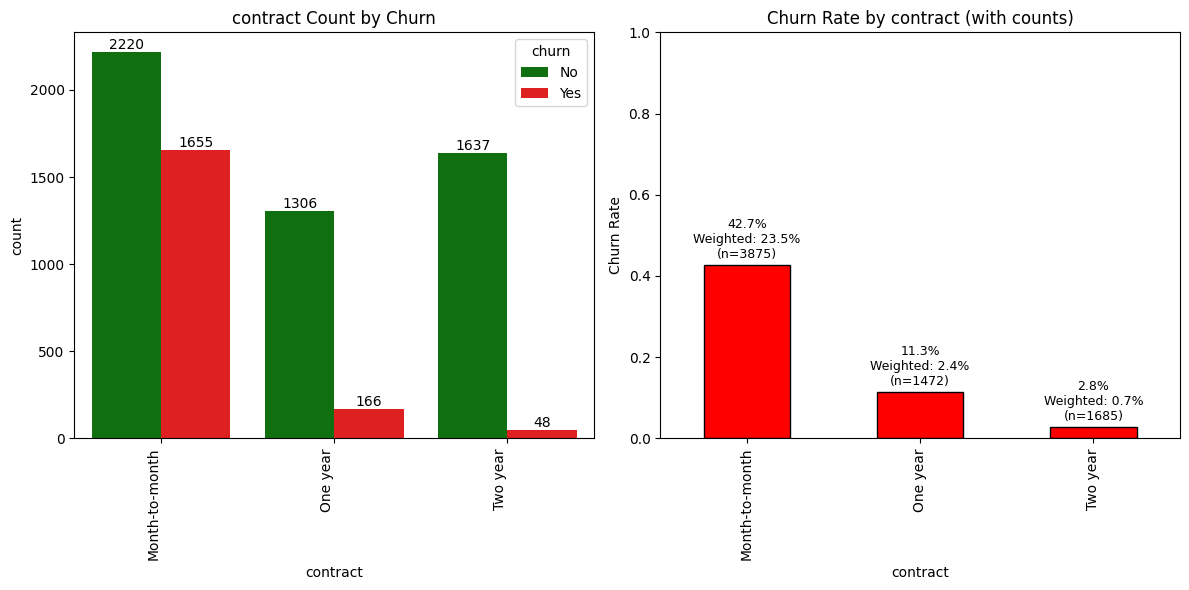

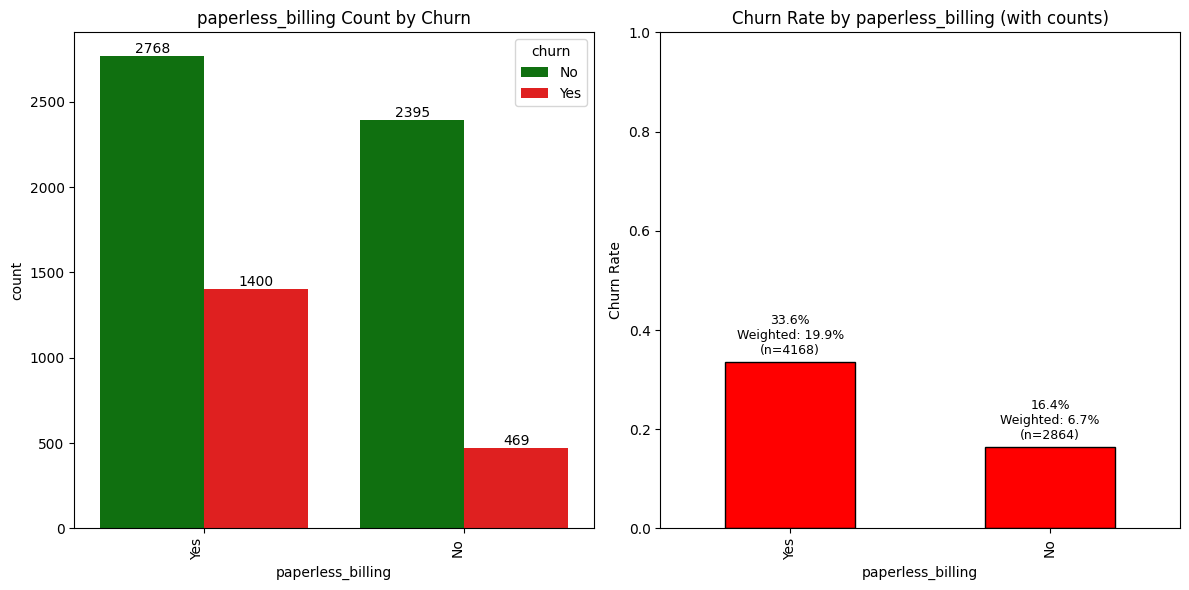

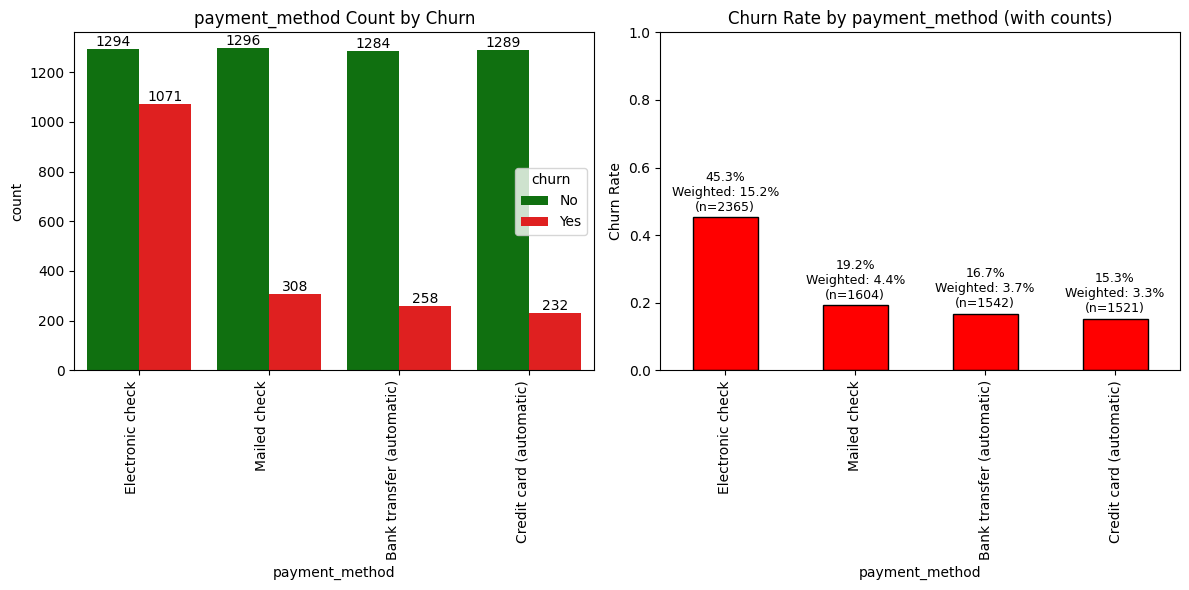

,column,category,churn_rate,weighted_churn
0,gender,Female,0.269595,0.133532
1,gender,Male,0.262046,0.132253
2,senior_citizen,Yes,0.416813,0.067691
3,senior_citizen,No,0.236503,0.198094
4,partner,No,0.329761,0.170648
5,partner,Yes,0.197171,0.095137
6,dependents,No,0.312791,0.219425
7,dependents,Yes,0.155312,0.046359
8,phone_service,Yes,0.267475,0.241610
9,phone_service,No,0.250000,0.024175


In [38]:
categorical_cols = df.select_dtypes(include='object').drop(columns=['churn']).columns
colors = {'Yes': 'red', 'No': 'green'}
total_users = len(df)
stat_summary = []

for name in categorical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1 = sns.countplot(
        data=df,
        x=name,
        hue='churn',
        palette=colors,
        ax=axes[0]
    )
    plt.setp(ax1.get_xticklabels(), rotation=90, ha='right')
    ax1.set_title(f'{name} Count by Churn')
    for container in ax1.containers:
        ax1.bar_label(container)
    
    rate_df = pd.DataFrame({
        'churn_rate': df.groupby(name)['churn'].apply(lambda x: (x=='Yes').mean()),
        'weighted_churn': df.groupby(name)['churn'].apply(lambda x: (x=='Yes').sum() / total_users),
        'count': df[name].value_counts()
    }).sort_values('churn_rate', ascending=False)
    
    stat_summary.append((name, rate_df['churn_rate'], rate_df['weighted_churn']))

    ax2 = rate_df['churn_rate'].plot(
        kind='bar',
        color='red',
        edgecolor='black',
        ax=axes[1]
    )
    ax2.set_ylabel('Churn Rate')
    ax2.set_ylim(0, 1)
    ax2.set_title(f'Churn Rate by {name} (with counts)')
    
    for i, bar in enumerate(ax2.patches):
        churn_pct = rate_df['churn_rate'].iloc[i]
        weighted_pct = rate_df['weighted_churn'].iloc[i]
        count = rate_df['count'].iloc[i]
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f'{churn_pct:.1%}\nWeighted: {weighted_pct:.1%}\n(n={count})',
            ha='center',
            va='bottom',
            fontsize=9
        )
    
    plt.tight_layout()
    plt.show()

unpacked_summary = []

for col_name, churn_rate, weighted_churn in stat_summary:
    df_summary = pd.DataFrame({
        'column': col_name,
        'category': churn_rate.index,
        'churn_rate': churn_rate.values,
        'weighted_churn': weighted_churn.values
    })
    unpacked_summary.append(df_summary)

final_summary_df = pd.concat(unpacked_summary, ignore_index=True)

final_summary_df

- customers with partners (Yes, 9.5%) and dependents (Yes, 4.64%) have lower weighted churn compared to those without partners (17.1%) or dependents (22%);
- fiber optic internet (18.4%) drives more weighted churn than DSL (6.5%) or no internet (1.6%);
- lack of online security (20.8%), tech support (20.6%), device protection (17.2%), and online backup (17.5%) are major weighted churn contributors; having these services reduces weighted churn to 4–7.7%;
- month-to-month contracts (23.5%) dominate weighted churn versus one-year (2.36%) and two-year (0.68%) contracts;
- paperless billing (Yes, 19.9%) contributes more to weighted churn than paper billing (6.7%);
- electronic check payments (15.2%) are the largest weighted churn among payment methods; automatic payments are much lower (3.3–3.7%);
- gender (Female 13.4%, Male 13.2%) and phone service (Yes 24.2%, No 2.4%) have relatively smaller weighted churn impact compared to services or contract type;

## Numerical Features Distribution with Churn

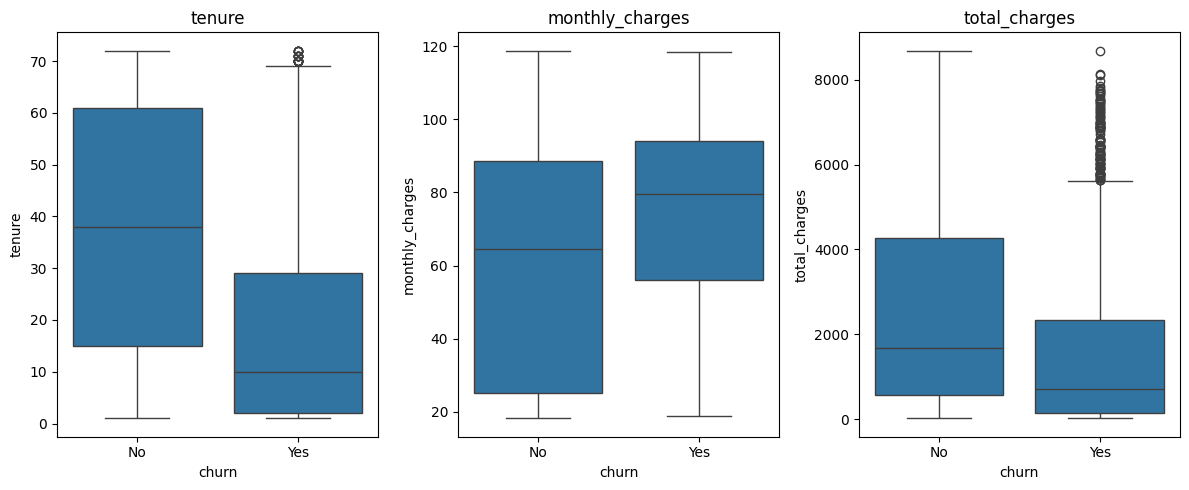

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i, col in enumerate(['tenure', 'monthly_charges', 'total_charges']):
    sns.boxplot(data=df, x='churn', y=col, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

- strong outliers are spotted on total_charges boxplot, but they can contribute in modeling; alternatively the total_charges can be binned as categories or dropped;

In [40]:
num_features = ['tenure', 'monthly_charges', 'total_charges']
churn_yes = df[df['churn'] == 'Yes']
churn_no  = df[df['churn'] == 'No']

print("Mann-Whitney U tests (numerical features vs churn):\n")
for col in num_features:
    stat, p = mannwhitneyu(churn_yes[col], churn_no[col], alternative='two-sided')
    sig = "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else "n.s."))
    print(f"  {col:20s}  U = {stat:,.0f}   p = {p:.2e}  {sig}")

Mann-Whitney U tests (numerical features vs churn):

  tenure                U = 2,494,979   p = 6.04e-211  ***
  monthly_charges       U = 5,986,148   p = 8.47e-54  ***
  total_charges         U = 3,360,665   p = 2.00e-84  ***


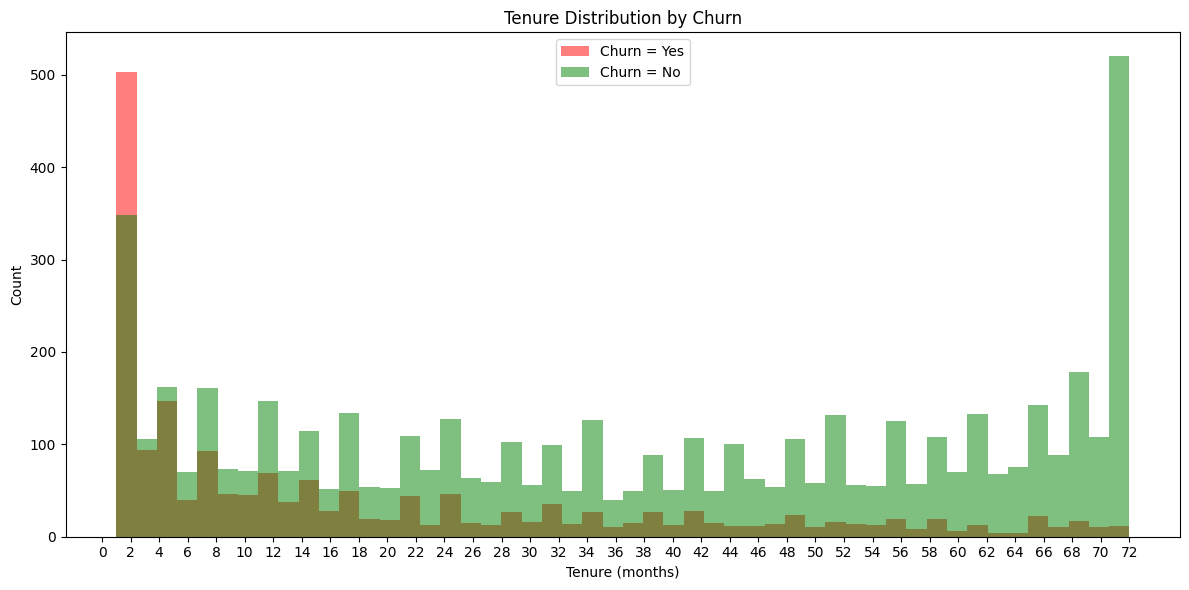

In [41]:
plt.figure(figsize=(12, 6))

plt.hist(
    df.loc[df['churn'] == 'Yes', 'tenure'],
    bins=50,
    alpha=0.5,
    label='Churn = Yes',
    color='red'
)

plt.hist(
    df.loc[df['churn'] == 'No', 'tenure'],
    bins=50,
    alpha=0.5,
    label='Churn = No',
    color='green'
)

plt.title('Tenure Distribution by Churn')
plt.xlabel('Tenure (months)')
plt.ylabel('Count')
plt.xticks(range(0, df['tenure'].max()+1, 2))
plt.legend()

plt.tight_layout()
plt.show()

- danger zone when early on tenure 0-4 months;
- the higher customers tenure the less churn;

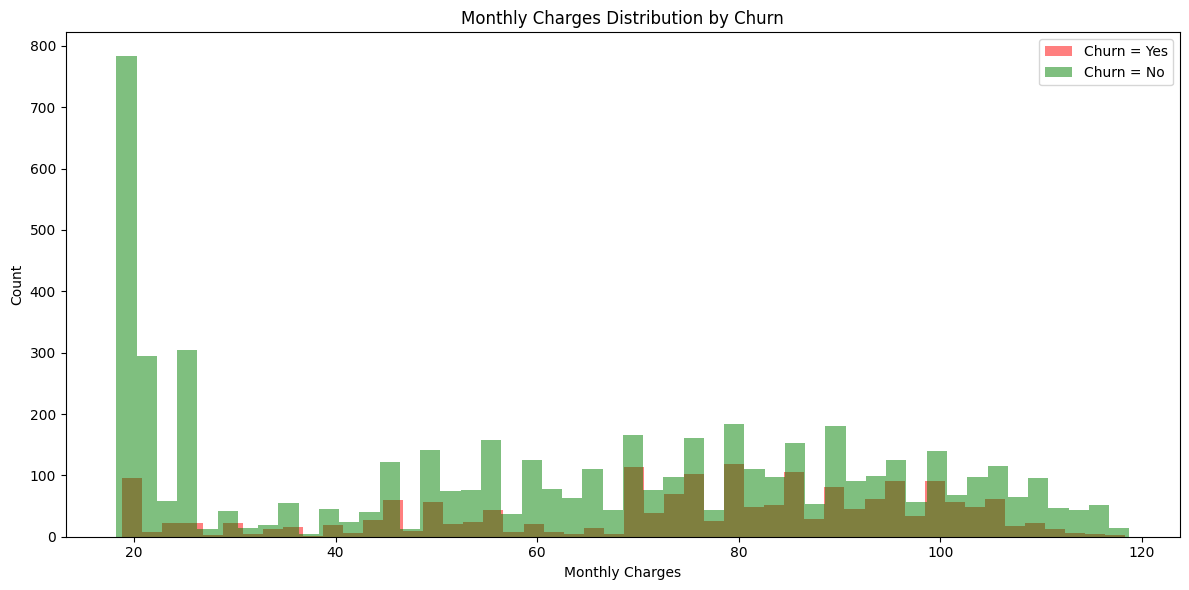

In [42]:
plt.figure(figsize=(12, 6))

plt.hist(
    df.loc[df['churn'] == 'Yes', 'monthly_charges'],
    bins=50,
    alpha=0.5,
    label='Churn = Yes',
    color='red'
)

plt.hist(
    df.loc[df['churn'] == 'No', 'monthly_charges'],
    bins=50,
    alpha=0.5,
    label='Churn = No',
    color='green'
)

plt.title('Monthly Charges Distribution by Churn')
plt.xlabel('Monthly Charges')
plt.ylabel('Count')

plt.legend()

plt.tight_layout()
plt.show()

- high churns are between approx. 50 and up to 108 monthly charges;

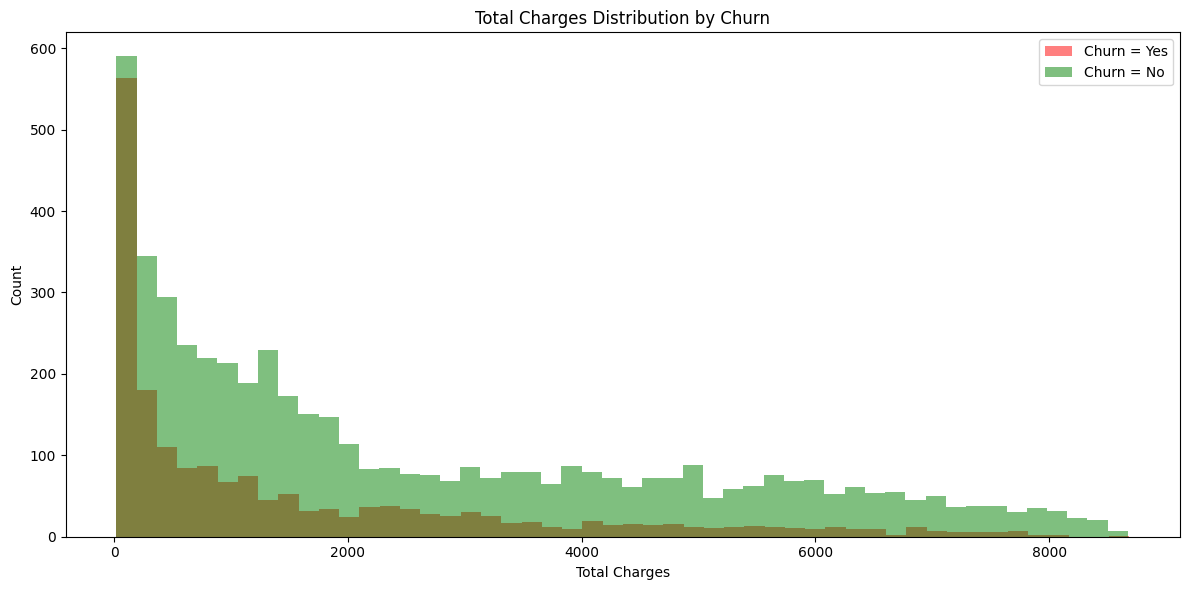

In [43]:
plt.figure(figsize=(12, 6))

plt.hist(
    df.loc[df['churn'] == 'Yes', 'total_charges'],
    bins=50,
    alpha=0.5,
    label='Churn = Yes',
    color='red'
)

plt.hist(
    df.loc[df['churn'] == 'No', 'total_charges'],
    bins=50,
    alpha=0.5,
    label='Churn = No',
    color='green'
)

plt.title('Total Charges Distribution by Churn')
plt.xlabel('Total Charges')
plt.ylabel('Count')

plt.legend()

plt.tight_layout()
plt.show()

- a lot of churners are having small total charges; confirms early churn;

### Correlation

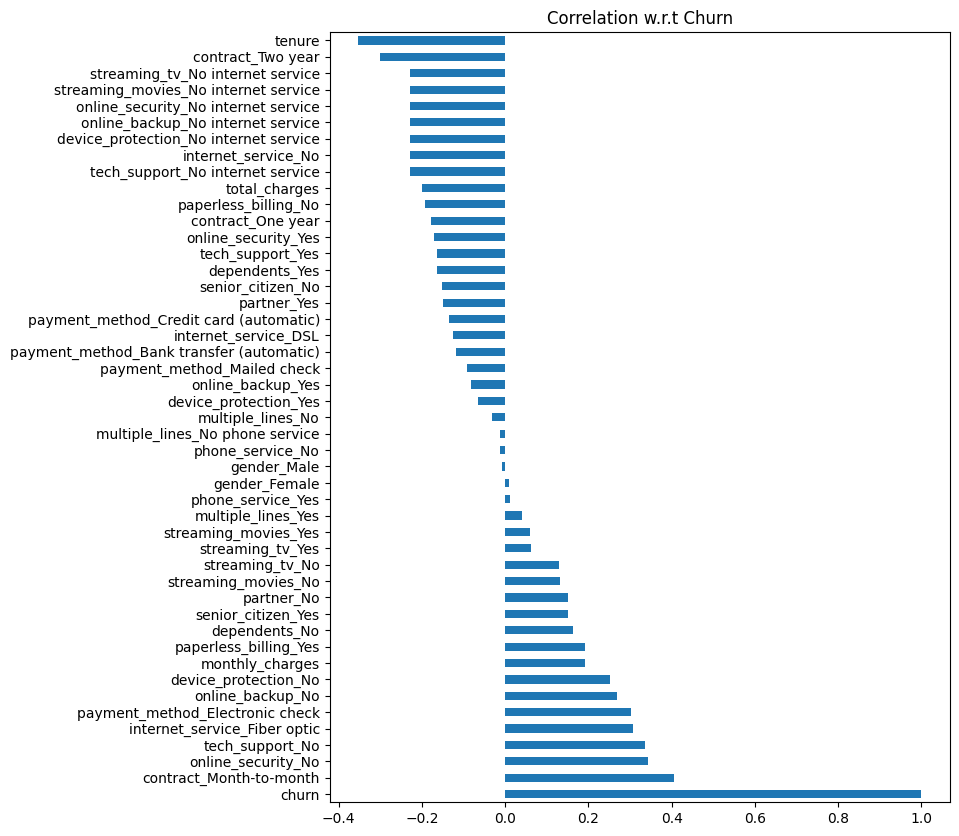

In [44]:
df_encoded_corr = pd.get_dummies(df, columns=categorical_cols)
df_encoded_corr['churn'] = df_encoded_corr['churn'].map({'Yes': 1, 'No': 0})

full_corr = df_encoded_corr.corr()
full_corr['churn'].sort_values(ascending=False).plot(kind='barh', figsize=(8, 10))
plt.title('Correlation w.r.t Churn')
plt.show()

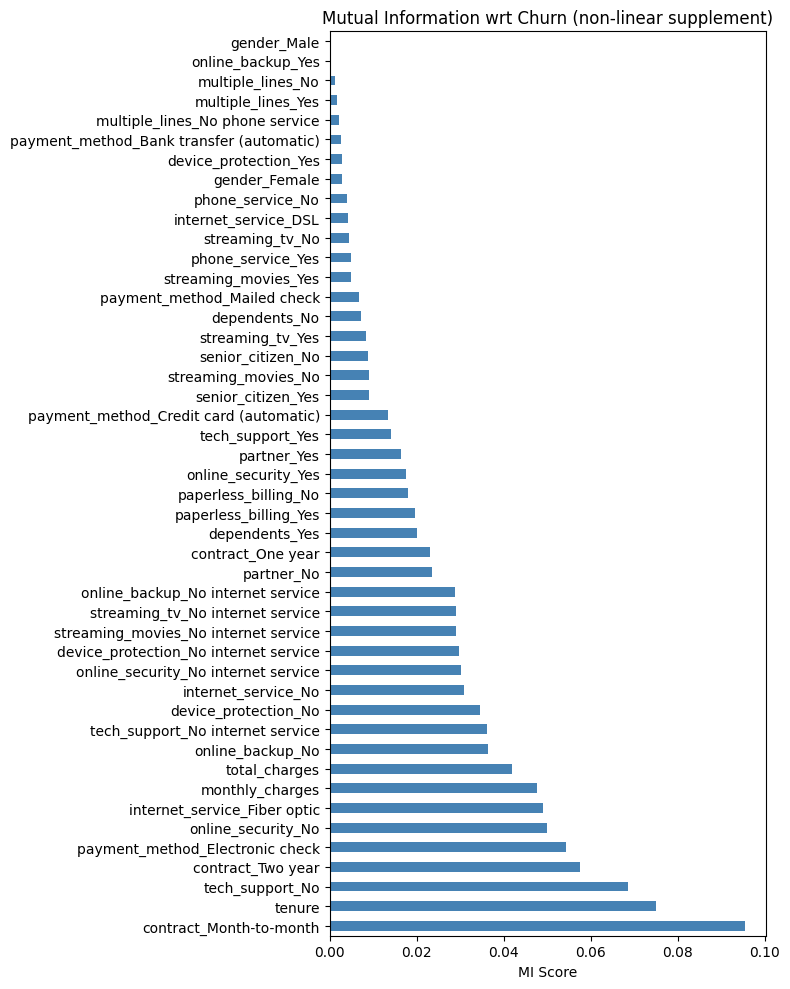

In [45]:
X_mi = df_encoded_corr.drop(columns='churn')
y_mi = df_encoded_corr['churn']

mi_scores = mutual_info_classif(X_mi, y_mi, discrete_features='auto', random_state=11)
mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)

mi_series.plot(kind='barh', figsize=(8, 10), color='steelblue')
plt.title('Mutual Information wrt Churn (non-linear supplement)')
plt.xlabel('MI Score')
plt.tight_layout()
plt.show()

### Correlation & MutualInfo Findings & Hypotheses

strong positive correlation & MI score:
- contract month-to-month as top driver for churn; ---> investigate distribution of contract and tenure w.r.t. churn;
- users without tech support have higher chance to turn over ---> possible connection to fiber optic, check the distribution of tech support lack and connection type w.r.t. churn;
- having electronic check as payment method ---> suspecting churn due to high payment friction or forgetting to pay (leads to automatic cut off), check distribution of payment method, tenure, contract type with churn;
- online security service absence ---> can be a marker of unengaged users, financial status or online fraud;
- fiber optic as internet connection ---> can be due to competitors prices (collect info on competitors prices), end of our offers (check our current & recent offers), poor or absence of tech support (check distribution);
- monthly charges ---> investigate distribution of monthly charges and tenure w.r.t. churn;

strong negative correlation & MI score:
- tenure, the longer customers with us, the less likely they to leave ---> strong marker of loyal customers;
- customers on 2 year contract ---> commitment marker, if the dist of month-to-month sits on early tenure, then there is an actionable strategy;
- total charges ---> the longer the tenure the bigger the total charges, for linear reg a good indicator;

paradox:
- total charges (strong negative corr) with monthly charges (strong positive corr), longer tenure has higher total charger ---> total charges are having negative corr, create bins for total charges; alternatively drop total charges for linear reg traning;

priority:
- month-to-month contract dist & other contracts with tenure and churn;
- tech support & fiber optic;
- payment method distribution (friction/forgetfulness hypothesis);

## Numeric & Categorical Multivariate Analysis

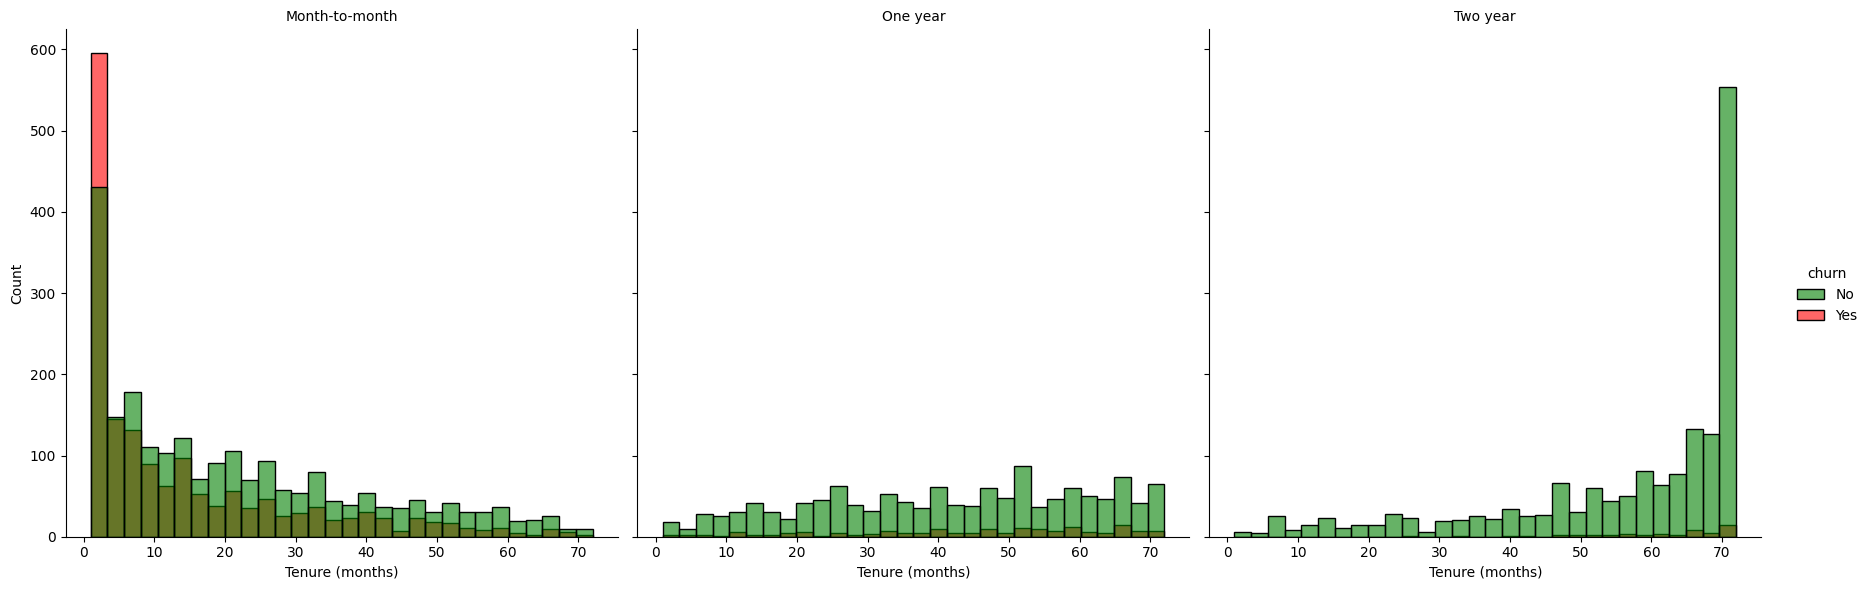

In [46]:
g = sns.displot(
    data=df, 
    x='tenure', 
    hue='churn', 
    col='contract',      
    kind='hist', 
    bins=30,              
    kde=False,             
    palette={'Yes': 'red', 'No': 'green'},
    alpha=0.6,          
    multiple='layer',     
    height=6, 
    aspect=1
)

g.set_axis_labels('Tenure (months)', 'Count')
g.set_titles("{col_name}")
plt.show()

- most of the customers either on the left extreme (tenure start) or on the right (longest tenure);
- a significant portion of customers who joined recently (early tenure) have already left (churned), simultaneously, there remains a substantial group of early-tenure customers who have not churned;

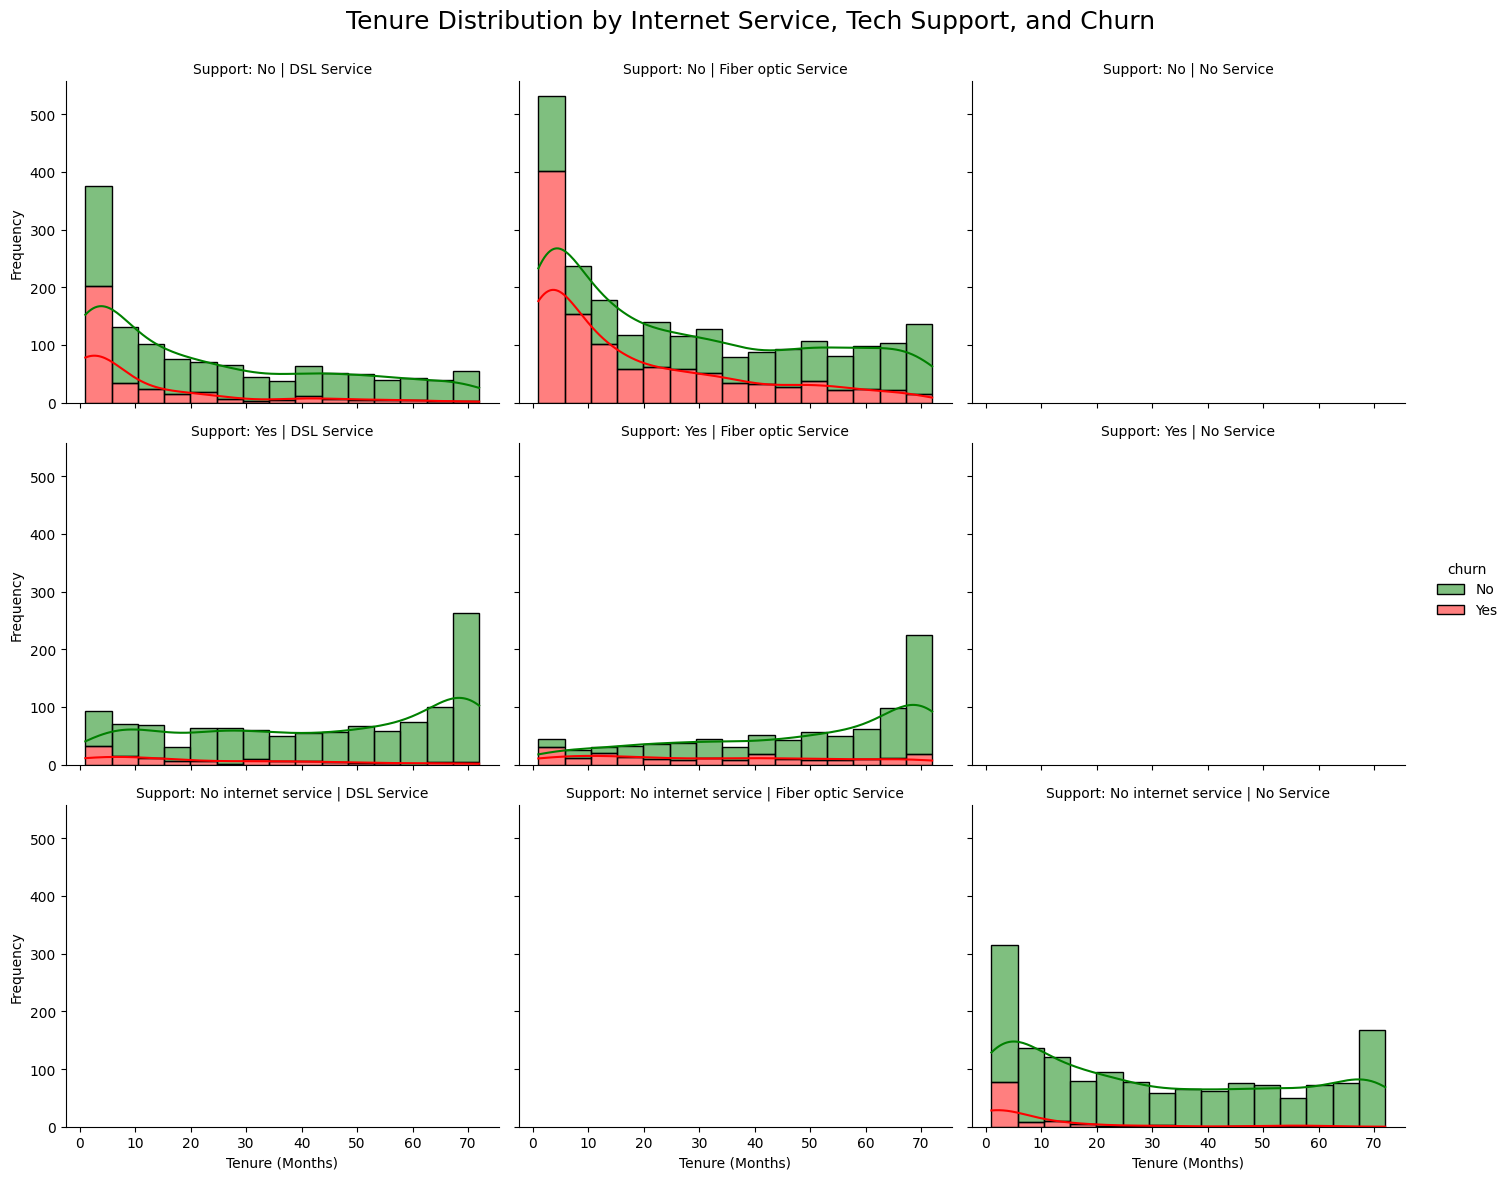

In [47]:
g = sns.displot(
    data=df, 
    x='tenure', 
    hue='churn', 
    col='internet_service', 
    row='tech_support', 
    kind='hist', 
    kde=True,
    palette={'Yes': 'red', 'No': 'green'},
    multiple='stack',
    height=4,          
    aspect=1.2
)

g.set_axis_labels('Tenure (Months)', 'Frequency')
g.set_titles(col_template="{col_name} Service", row_template="Support: {row_name}")
g.fig.suptitle('Tenure Distribution by Internet Service, Tech Support, and Churn', fontsize=18)

plt.subplots_adjust(top=0.92)
plt.show()

- churn among fiber optic users without tech support is consistently elevated, particularly during the first 10 months of tenure;
- there is negligible amount of customers on early tenure with fiber optic and tech support present;

In [48]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24, 36, 48, float('inf')]

labels = ['1 month', '2 months', '3 months', '4 months', '5 months', '6 months', 
          '7 months', '8 months', '9 months', '10 months', '11 months', '12 months',
          '1-2 years', '2-3 years', '3-4 years', '4+ years']

df['tenure_categorized'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=True)

C:\Users\zxrco\AppData\Local\Temp\ipykernel_12788\868463276.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(


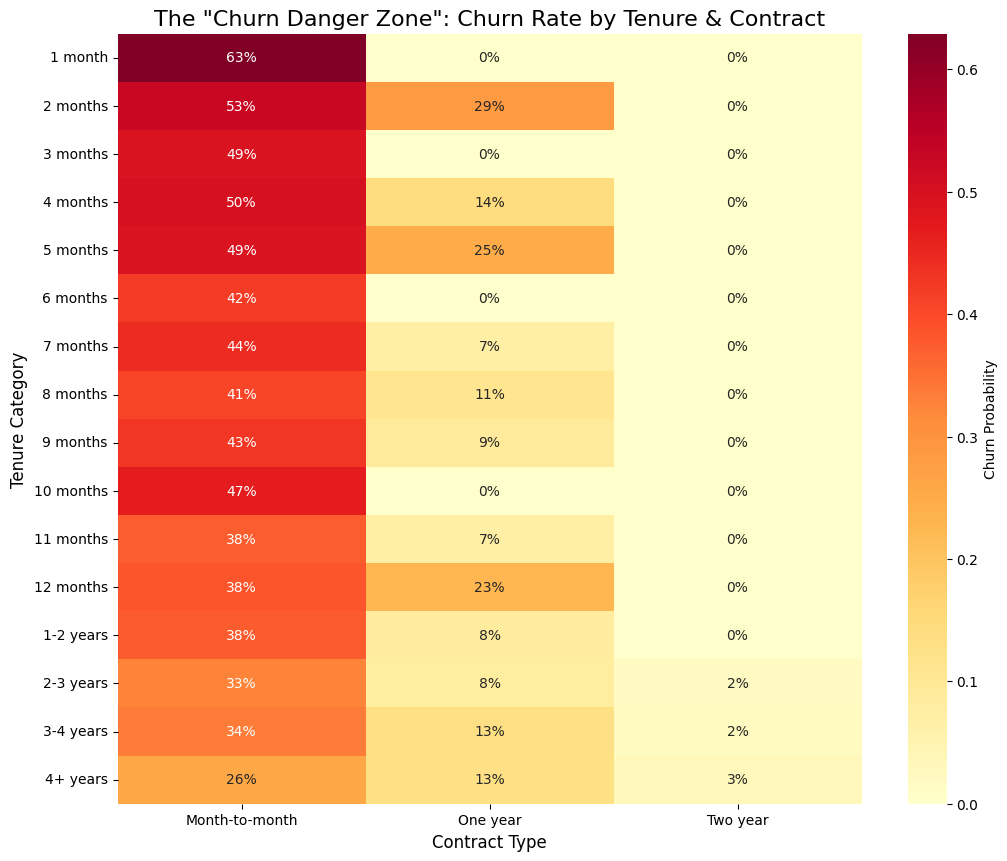

In [49]:
df['churn_rate'] = df['churn'].apply(lambda x: 1 if x == 'Yes' else 0)

heatmap_data = df.pivot_table(
    index='tenure_categorized', 
    columns='contract', 
    values='churn_rate', 
    aggfunc='mean'
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data, 
    annot=True,         
    fmt=".0%",           
    cmap="YlOrRd",       
    cbar_kws={'label': 'Churn Probability'}
)

plt.title('The "Churn Danger Zone": Churn Rate by Tenure & Contract', fontsize=16)
plt.ylabel('Tenure Category', fontsize=12)
plt.xlabel('Contract Type', fontsize=12)
plt.show()

- the highest turn rate of those with month-to-month contract and early on tenure; 
- first 5 months it shows churn of approx 50+%;
- the customers with month-to-month contract have significantly higher churn rate even after early tenure;

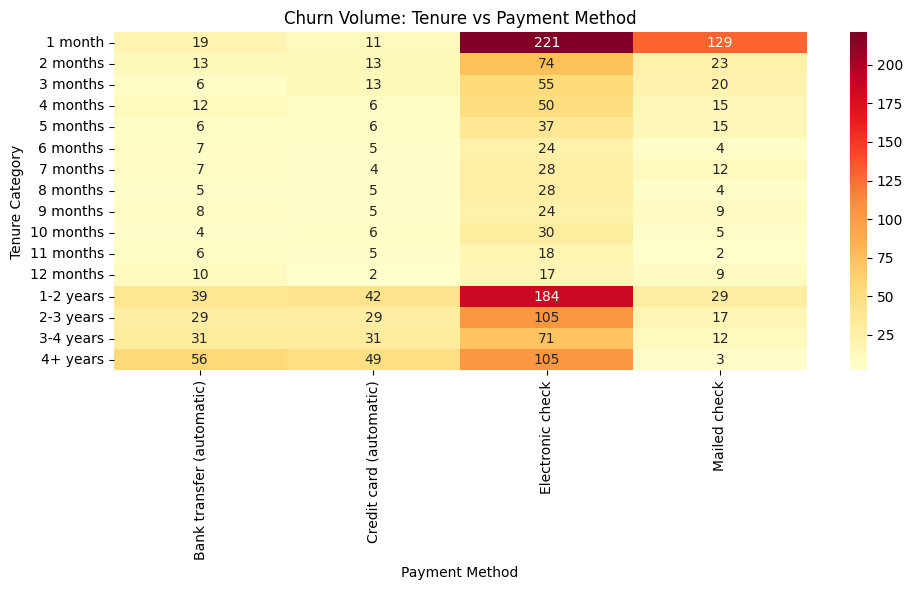

In [50]:
churned_df = df[df['churn'] == 'Yes'].copy()

pivot_table = pd.crosstab(
    churned_df['tenure_categorized'],
    churned_df['payment_method']
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt="d",           
    cmap="YlOrRd"
)

plt.title('Churn Volume: Tenure vs Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Tenure Category')

plt.tight_layout()
plt.show()


- customers using electronic check exhibit significantly higher churn, suggesting the need to enrich data with financial status indicators;

In [51]:
eda_cols = [c for c in ['tenure_categorized', 'churn_rate'] if c in df.columns]
if eda_cols:
    df.drop(columns=eda_cols, inplace=True)
    print(f"Dropped EDA-only columns: {eda_cols}")

pd_to_csv_path = os.path.join('..', 'data', '02_processed', 'customer_churn.csv')

os.makedirs(os.path.dirname(pd_to_csv_path), exist_ok=True)
df.to_csv(pd_to_csv_path, index=False)

print(f"Saved to: {pd_to_csv_path}")

Dropped EDA-only columns: ['tenure_categorized', 'churn_rate']
Saved to: ..\data\02_processed\customer_churn.csv


In [52]:
df.columns.tolist()

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'churn']

---

## Final Conclusion & Retention Plan

### Key Findings

**Overall churn rate is ~26%**, with a heavily imbalanced dataset (~5k retained vs ~2k churned), which must be accounted for in modeling.

**Top churn drivers ranked by impact:**

| Driver | Weighted Churn | Key Signal |
|---|---|---|
| Month-to-month contract | 23.5% | 50%+ churn in first 5 months |
| No online security | 20.8% | Marker of low service engagement |
| No tech support | 20.6% | Especially acute with fiber optic |
| No partner / dependents | 17–22% | Less "anchored" customers |
| Electronic check payment | 15.2% | Friction / payment failure risk |
| Fiber optic internet | 18.4% | Price sensitivity or service quality gap |
| Monthly charges $50–$110 | — | High-bill segment at risk |
| Early tenure (0–4 months) | ~50%+ (M2M) | Onboarding failure window |

**Numeric patterns:** Tenure is the strongest loyalty signal — the longer a customer stays, the less likely they are to leave. Total charges correlate negatively with churn (tenure proxy), while higher monthly charges correlate positively.

**Negligible factors:** Gender shows virtually no churn difference (Female 13.4% vs Male 13.2%). Phone service presence has limited predictive lift on its own.

---

### Retention Plan

**1. Eliminate the early-tenure danger zone (months 0–5)**
Targeted onboarding campaign for new month-to-month customers: proactive check-in calls/emails at month 1 and month 3, a "welcome bundle" discount (e.g., free security add-on for 3 months), and a clear upgrade path to annual contracts.

**2. Migrate month-to-month customers to longer contracts**
Offer a time-limited incentive (locked-in rate, one-time bill credit) to flip high-risk M2M customers to 1-year contracts. Even moving a portion of this segment reduces weighted churn from 23.5% toward the 2.4% seen on annual contracts.

**3. Promote add-on adoption (security, tech support, backup)**
Bundle online security and tech support into mid-tier plans by default. Customers with these services show 4–8% weighted churn vs 17–21% without. Frame this as value, not upsell.

**4. Address fiber optic dissatisfaction**
Fiber optic users without tech support are the highest-risk cohort in early tenure. Deploy proactive tech support outreach specifically for this group (automated ticket check-ins, dedicated support tier) and audit pricing vs. competitor offerings.

**5. Automate payments to reduce friction**
Electronic check users have ~4× the churn of automatic payment users. Incentivize switching (e.g., $5/month discount for auto-pay enrollment). This is a low-cost, high-impact lever.
